In [1]:
!pip install transformers

     |████████████████████████████████| 2.6 MB 34.6 MB/s 
     |████████████████████████████████| 3.3 MB 56.6 MB/s 
     |████████████████████████████████| 895 kB 65.4 MB/s 
     |████████████████████████████████| 636 kB 59.1 MB/s 
  Attempting uninstall: pyyaml
    Found existing installation: PyYAML 3.13
    Uninstalling PyYAML-3.13:
      Successfully uninstalled PyYAML-3.13


In [2]:
from transformers import BertTokenizer, BertForSequenceClassification, AdamW, BertConfig, get_linear_schedule_with_warmup
import torch
import pandas as pd
import numpy as np
import time
import datetime
import random
import matplotlib.pyplot as plt
import plotly.express as px
from sklearn.model_selection import train_test_split
from keras.preprocessing.sequence import pad_sequences
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler

In [3]:
# 檢查GPU環境
if torch.cuda.is_available():
    print ("yes")
else:
    print("no")
    
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

yes


In [4]:
seed_val = 666

random.seed(seed_val)
np.random.seed(seed_val)
torch.manual_seed(seed_val)
torch.cuda.manual_seed_all(seed_val)

# Load Dataset

In [5]:
df = pd.read_excel("/content/testing_data(labeled).xlsx")
print(df.head())
print(df.sample(10))

                                        sentences  labels
0  When did Beyoncé release her first solo album?       2
1     Who is Beyoncé's biggest musical influence?       2
2             How many octaves does Beyoncé have?       1
3   How many copies did 4 sell in the first week?       0
4         How many Grammy Awards has Beyoncé won?       1
                                            sentences  labels
91        Where are the wax figures of Beyoncé found?       0
53  What was the first African-American woman to w...       0
35        When did Beyoncé perform at the Super Bowl?       2
37                Who is the inspiration for Beyoncé?       2
43                       Who is Beyoncé's influences?       1
6             How many Grammy Awards has Beyoncé won?       2
17  What is the first single from Dangerously in L...       0
72  How many Grammy Awards has Beyoncé won in one ...       2
86           What genres do Beyoncé use in her music?       2
66             Who is the greate

In [6]:
# Get the lists of sentences and their labels.
sentences = df.sentences.values
labels = df.labels.values

In [7]:
# check class distribution
df.labels.value_counts(normalize = True)

2    0.53
1    0.35
0    0.12
Name: labels, dtype: float64

# 將sentence轉成token

In [8]:
## 範例的：載入BERT tokenizer
print('==== Loading BERT tokenizer ====\n')
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

==== Loading BERT tokenizer ====



In [9]:
input_ids = []
for sent in sentences:
    encoded_sent = tokenizer.encode(
        sent,
        add_special_tokens = True, # Add '[CLS]' and '[SEP]' 
    )
    input_ids.append(encoded_sent)
    
print('==== Tokenized Sentences ====\n')  
print('Original: ', sentences[0])
print('Token IDs:', input_ids[0])

==== Tokenized Sentences ====

Original:  When did Beyoncé release her first solo album?
Token IDs: [101, 2043, 2106, 20773, 2713, 2014, 2034, 3948, 2201, 1029, 102]


In [10]:
max_seq_len = max([len(sen) for sen in input_ids])
print('Max sentence length: ', max_seq_len)

Max sentence length:  21


In [11]:
MAX_LEN = max_seq_len
print('\nPadding/truncating all sentences to %d values...' % MAX_LEN)
print('\nPadding token: "{:}", ID: {:}'.format(tokenizer.pad_token, tokenizer.pad_token_id))
# Pad our input tokens with value 0.
# "post" indicates that we want to pad and truncate at the end of the sequence,
# as opposed to the beginning.
input_ids = pad_sequences(input_ids, maxlen=MAX_LEN, dtype="long", 
                          value=0, truncating="post", padding="post")
print('\Done.')


Padding/truncating all sentences to 21 values...

Padding token: "[PAD]", ID: 0
\Done.


In [12]:
# attention masks
attention_masks = []

for sent in input_ids:
    att_mask = [int(token_id > 0) for token_id in sent]
    attention_masks.append(att_mask)

# Split train dataset into train, validation and test sets

In [13]:
## 準備訓練集、驗證集 
train_inputs, validation_inputs, train_labels, validation_labels = train_test_split(
                input_ids, labels, random_state = 2021, 
                test_size=0.2, 
                )

# 同樣masks
train_masks, validation_masks, _, _ = train_test_split(
                attention_masks, labels,                                     random_state=2021,
                test_size=0.2,
                )

In [14]:
# 轉換成torch tensors
train_inputs = torch.tensor(train_inputs).to(device)
validation_inputs = torch.tensor(validation_inputs).to(device)
train_labels = torch.tensor(train_labels).to(device)
validation_labels = torch.tensor(validation_labels).to(device)
train_masks = torch.tensor(train_masks).to(device)
validation_masks = torch.tensor(validation_masks).to(device)

In [15]:
# The DataLoader
batch_size = 16

# 建立訓練集的DataLoader
train_data = TensorDataset(train_inputs, train_masks, train_labels)
train_sampler = RandomSampler(train_data)
train_dataloader = DataLoader(train_data, sampler=train_sampler, batch_size=batch_size)

# 建立驗證集的DataLoader
validation_data = TensorDataset(validation_inputs, validation_masks, validation_labels)
validation_sampler = SequentialSampler(validation_data)
validation_dataloader = DataLoader(validation_data, sampler=validation_sampler, batch_size=batch_size)

# Import BERT-base pretrained model

In [16]:
## Load BertForSequenceClassification, the pretrained BERT model with a single
model = BertForSequenceClassification.from_pretrained(
        'bert-base-uncased',
        num_labels = 3,
        output_attentions = False,
        output_hidden_states = False,
        )

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.predictions.transform.LayerNorm.weight', 'cls.predictions.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at

In [17]:
# Get all of the model's parameters as a list of tuples.
params = list(model.named_parameters())
print('The BERT model has {:} different named parameters.\n'.format(len(params)))
print('==== Embedding Layer ====\n')
for p in params[0:5]:
    print("{:<55} {:>12}".format(p[0], str(tuple(p[1].size()))))
print('\n==== First Transformer ====\n')
for p in params[5:21]:
    print("{:<55} {:>12}".format(p[0], str(tuple(p[1].size()))))
print('\n==== Output Layer ====\n')
for p in params[-4:]:
    print("{:<55} {:>12}".format(p[0], str(tuple(p[1].size()))))

The BERT model has 201 different named parameters.

==== Embedding Layer ====

bert.embeddings.word_embeddings.weight                  (30522, 768)
bert.embeddings.position_embeddings.weight                (512, 768)
bert.embeddings.token_type_embeddings.weight                (2, 768)
bert.embeddings.LayerNorm.weight                              (768,)
bert.embeddings.LayerNorm.bias                                (768,)

==== First Transformer ====

bert.encoder.layer.0.attention.self.query.weight          (768, 768)
bert.encoder.layer.0.attention.self.query.bias                (768,)
bert.encoder.layer.0.attention.self.key.weight            (768, 768)
bert.encoder.layer.0.attention.self.key.bias                  (768,)
bert.encoder.layer.0.attention.self.value.weight          (768, 768)
bert.encoder.layer.0.attention.self.value.bias                (768,)
bert.encoder.layer.0.attention.output.dense.weight        (768, 768)
bert.encoder.layer.0.attention.output.dense.bias              (

In [18]:
# to cuda
model.to(device)

BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0): BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, element

In [19]:
optimizer = AdamW(model.parameters(),
                  lr = 2e-5, # args.learning_rate - default is 5e-5, our notebook had 2e-5
                  eps = 1e-8 # args.adam_epsilon  - default is 1e-8.
                )
                
epochs = 4 # authors recommend between 2 and 4
total_steps = len(train_dataloader) * epochs
# Create the learning rate scheduler.
scheduler = get_linear_schedule_with_warmup(
                optimizer, 
                num_warmup_steps = 0, # Default value
                num_training_steps = total_steps
                )

In [20]:
def flat_accuracy(preds, labels):
    pred_flat = np.argmax(preds, axis=1).flatten()
    labels_flat = labels.flatten()
    return np.sum(pred_flat == labels_flat) / len(labels_flat)

In [21]:
def format_time(elapsed):
    '''
    Takes a time in seconds and returns a string hh:mm:ss
    '''
    # Round to the nearest second.
    elapsed_rounded = int(round((elapsed)))
    
    # Format as hh:mm:ss
    return str(datetime.timedelta(seconds=elapsed_rounded))

In [22]:
loss_values = []
val_loss_value = []

# Train Process

In [23]:
# 統計整個訓練時長
total_t0 = time.time()

# For each Training epoch
for epoch_i in range(0, epochs):
    
    # ========================================
    #         Training
    # ========================================
    print('======== Epoch {:} / {:} ========'.format(epoch_i + 1, epochs))
    print('======== Training ========')    
    t0 = time.time()# Measure how long the training epoch takes.    
    total_loss = 0 # Reset the total loss for this epoch.
    model.train()
    for step, batch in enumerate(train_dataloader):
        # 每經過N次迭代，就輸出進度資訊
        if step % 5 == 0 and not step == 0:
            elapsed = format_time(time.time() - t0)
            print('  Batch {:>5,}  of  {:>5,}.    Elapsed: {:}.'.format(step, len(train_dataloader), elapsed))
        
        b_input_ids = batch[0].to(device)
        b_input_mask = batch[1].to(device)
        b_labels = batch[2].to(device)
        
        model.zero_grad()
        
        outputs = model(b_input_ids, 
                    token_type_ids=None, 
                    attention_mask=b_input_mask, 
                    labels=b_labels)
        
        loss = outputs[0]
        total_loss += loss.item()
        loss.backward()
        
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
        optimizer.step()
        scheduler.step()
        
    avg_train_loss = total_loss / len(train_dataloader)
    
    loss_values.append(avg_train_loss)
    #print("")
    print("  Average training loss: {0:.2f}".format(avg_train_loss))
    print("  Training epcoh took: {:}".format(format_time(time.time() - t0)))
    
    # ========================================
    #        Validation
    # ========================================
    
    print("")
    print("======== Running Validation ========")
    t0 = time.time()
    
    model.eval()
    
    eval_loss, eval_accuracy = 0, 0
    nb_eval_steps, nb_eval_examples = 0, 0
    
    for batch in validation_dataloader:
        batch = tuple(t.to(device) for t in batch)
        b_input_ids, b_input_mask, b_labels = batch
        
        with torch.no_grad():
            outputs = model(b_input_ids, 
                        token_type_ids = None, 
                        attention_mask = b_input_mask)
        logits = outputs[0]
        # 累加 loss
        eval_loss += loss.item()

        logits = logits.detach().cpu().numpy()
        label_ids = b_labels.to('cpu').numpy()
        
        tmp_eval_accuracy = flat_accuracy(logits, label_ids)
        
        eval_accuracy += tmp_eval_accuracy
        nb_eval_steps += 1
    
    avg_val_loss = eval_loss / nb_eval_steps # len(validation_dataloader)
    avg_val_accuracy = eval_accuracy/nb_eval_steps
    validation_time = format_time(time.time() - t0)

    val_loss_value.append(avg_val_loss)

    #print("")
    print("  Accuracy: {0:.2f}".format(avg_val_accuracy))
    print("  Loss: {0:.2f}".format(avg_val_loss))
    print("  Validation took: {:}".format(validation_time))
    print("")
    
print("Training complete!")
print("Total training took {:} (h:mm:ss)".format(format_time(time.time()-total_t0)))

======== Epoch 1 / 4 ========
======== Training ========
  Average training loss: 0.99
  Training epcoh took: 0:00:01

======== Running Validation ========
  Accuracy: 0.62
  Loss: 0.88
  Validation took: 0:00:00

======== Epoch 2 / 4 ========
======== Training ========
  Average training loss: 0.91
  Training epcoh took: 0:00:00

======== Running Validation ========
  Accuracy: 0.62
  Loss: 0.93
  Validation took: 0:00:00

======== Epoch 3 / 4 ========
======== Training ========
  Average training loss: 0.85
  Training epcoh took: 0:00:00

======== Running Validation ========
  Accuracy: 0.75
  Loss: 0.78
  Validation took: 0:00:00

======== Epoch 4 / 4 ========
======== Training ========
  Average training loss: 0.79
  Training epcoh took: 0:00:00

======== Running Validation ========
  Accuracy: 0.75
  Loss: 0.66
  Validation took: 0:00:00

Training complete!
Total training took 0:00:02 (h:mm:ss)


In [24]:
f = pd.DataFrame(loss_values)
f.columns=['Loss']
fig = px.line(f, x=f.index, y=f.Loss)
fig.update_layout(title='Training loss of the Model',
                   xaxis_title='Epoch',
                   yaxis_title='Loss')
fig.show()

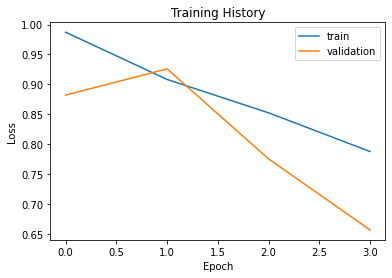

In [25]:
def show_train_history(train, validation):
    plt.plot(train)
    plt.plot(validation)
    plt.title('Training History')
    plt.ylabel("Loss")
    plt.xlabel("Epoch")
    plt.legend(['train','validation'],loc='upper right') 
    plt.show()

show_train_history(loss_values, val_loss_value)

In [26]:
torch.save(model, 'model.pth')

In [27]:
# 保存訓練好的權重
torch.save(model.state_dict(), 'model_state_dict.pt')